# Word2Vec (Negative Sampling)

In [58]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt

In [3]:
np.__version__, torch.__version__, matplotlib.__version__

('1.25.2', '2.1.0', '3.7.2')

## 1. Load data

In [4]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", "grape apple apple",
          "dog cat animal", "cat dog animal", "cat animal dog", "fish dog dog"]

### 1.1 tokenization

In [6]:
# 1. tokenization
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['grape', 'apple', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog'],
 ['fish', 'dog', 'dog']]

### 1.2 numericalization

In [10]:
# 2. numericalization

# get the unique word
flatten = lambda l:[item for sublist in l for item in sublist]

# assign the unique integer
vocabs = list(set(flatten(corpus))) # all the words we have in the system - <UNK>

In [11]:
vocabs

['fish', 'dog', 'grape', 'cat', 'animal', 'fruit', 'apple', 'banana']

In [12]:
# create handy mapping between integer and word
word2index = {v:idx for idx,v in enumerate(vocabs)}

In [13]:
word2index

{'fish': 0,
 'dog': 1,
 'grape': 2,
 'cat': 3,
 'animal': 4,
 'fruit': 5,
 'apple': 6,
 'banana': 7}

In [14]:
word2index['fish']

0

In [15]:
# append <UNK> for unknow word
vocabs.append('<UNK>')
word2index['<UNK>'] = 8

In [16]:
word2index

{'fish': 0,
 'dog': 1,
 'grape': 2,
 'cat': 3,
 'animal': 4,
 'fruit': 5,
 'apple': 6,
 'banana': 7,
 '<UNK>': 8}

In [18]:
index2word = {idx:v for v,idx in word2index.items()}

In [19]:
index2word

{0: 'fish',
 1: 'dog',
 2: 'grape',
 3: 'cat',
 4: 'animal',
 5: 'fruit',
 6: 'apple',
 7: 'banana',
 8: '<UNK>'}

## 2. Prepare train data

In [20]:
# create pairs of center word and outside word

def random_batch (batch_size, corpus):
    
    skipgrams = []

    # loop each corpus
    for doc in corpus:

        # look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            
            # assign center word
            center = word2index[doc[i]]
            
            # assign outside word = 2 word (ws = 2)
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            
            # for each of these two outside words, we gonna append to a list of a pair(center,outside)
            for each_out in outside:
                
                # [center,outside1], [center, outside2]
                skipgrams.append([center, each_out])
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace = False)
    
    inputs, labels = [],[]
    for index in random_index:
        inputs.append([skipgrams[index][0]]) # [center word]
        labels.append([skipgrams[index][1]]) # [outside word]
        
    return np.array(inputs), np.array(labels)

In [22]:
# testing
x, y = random_batch(2, corpus)
x,y

(array([[3],
        [7]]),
 array([[1],
        [6]]))

In [23]:
x.shape # (batch_size, 1)

(2, 1)

In [24]:
y.shape # (batch_size, 1)

(2, 1)

## 3. Negative Sampling

### Unigram distribution

$$P(w) = U(w)^{3/4} / Z

In [35]:
z = 0.001

In [29]:
# calculate U(w)

# count
from collections import Counter

word_count = Counter(flatten(corpus))
print(word_count)

# get the total number of words
num_total_words = sum([c for w,c in word_count.items()])
print(num_total_words)

Counter({'apple': 5, 'dog': 5, 'banana': 3, 'fruit': 3, 'cat': 3, 'animal': 3, 'grape': 1, 'fish': 1})
24


In [30]:
vocabs

['fish', 'dog', 'grape', 'cat', 'animal', 'fruit', 'apple', 'banana', '<UNK>']

In [40]:
# cal U(w)

unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z )# just to get a greater number
    # print(v, uw)
    # print(v, uw_alpha)
    # print("---")
    unigram_table.extend([v] * uw_alpha)

Counter(unigram_table)

Counter({'dog': 308,
         'apple': 308,
         'cat': 210,
         'animal': 210,
         'fruit': 210,
         'banana': 210,
         'fish': 92,
         'grape': 92})

In [28]:
sum([c for w,c in word_count.items()])

24

## 4. Model

$$J_{neg-sample}(v_{c},o,U) = -\log(\sigma(u_{o}^{T}v_{c})) - \sum _{k=1}^{K} \log(\sigma(-u_{k}^{T}v_{c}))

In [41]:
def prepare_sequence (seq,word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'],seq))
    return torch.LongTensor(idxs)


In [50]:
# create negative function

import random

def negative_sampling(targets, unigram_table, k): # k = total neg samples
    batch_size  = targets.shape[0]
    neg_samples = []
    
    for i in range(batch_size): #(1, k) === (batch_size, k)
        target_index = targets[i].item()
        nsample      = []
        while(len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1)) # to get (1, k) we need to reshape, otherwise it remain the shape of k.
    
    return torch.cat(neg_samples) # batch_size, k

In [43]:
batch_size = 2
x,y = random_batch(batch_size, corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [44]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [45]:
neg_samples.shape

torch.Size([2, 5])

In [46]:
neg_samples[0]

tensor([3, 4, 5, 1, 4])

In [47]:
y_tensor[0]

tensor([6])

In [48]:
neg_samples[1]

tensor([1, 4, 4, 1, 1])

In [49]:
y_tensor[1]

tensor([6])

In [51]:
# create model

class SkipgramNeg (nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
            
    def forward (self, center, outside, negative_words):
        
        # center, outside: (batch_size, 1)
        # negative       : (batch_size, k)
        
        center_embed   = self.embedding_center(center)          # (bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside)        # (bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative_words) # (bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1,2)).squeeze(2)   # (bs,1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1,2)).squeeze(2) # (bs,k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1,1) # (bs,1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [52]:
x_tensor, y_tensor

(tensor([[5],
         [7]]),
 tensor([[6],
         [6]]))

In [55]:
neg_samples

tensor([[3, 4, 5, 1, 4],
        [1, 4, 4, 1, 1]])

In [53]:
# testing my model

emb_size = 2
voc_size = len(vocabs)
model    = SkipgramNeg(voc_size, emb_size)

In [57]:
loss = model(x_tensor, y_tensor, neg_samples)
loss

tensor(2.3149, grad_fn=<NegBackward0>)

## 5. Training

In [59]:
k = 5
emb_size = 2
voc_size = len(vocabs)
model    = SkipgramNeg(voc_size, emb_size)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [63]:
num_epochs = 10000

for epoch in range(num_epochs):
    
    # get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    # predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model (input_tensor, label_tensor, neg_samples)
    
    # backpropagate
    optimizer.zero_grad()
    loss.backward()
    
    # update alpha
    optimizer.step()
    
    # print loss
    if (epoch+1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss {loss:2.6f}")
    

Epoch   1000 | Loss 0.413741
Epoch   2000 | Loss 1.041470
Epoch   3000 | Loss 1.835702
Epoch   4000 | Loss 1.325178
Epoch   5000 | Loss 1.214030
Epoch   6000 | Loss 0.378955
Epoch   7000 | Loss 0.681955
Epoch   8000 | Loss 0.683553
Epoch   9000 | Loss 0.825391
Epoch  10000 | Loss 0.832817


## 6. Plot the embeddings

In [64]:
vocabs

['fish', 'dog', 'grape', 'cat', 'animal', 'fruit', 'apple', 'banana', '<UNK>']

In [68]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([7])

In [69]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[0.3304, 0.2042]], grad_fn=<DivBackward0>)

In [70]:
def get_embed (word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

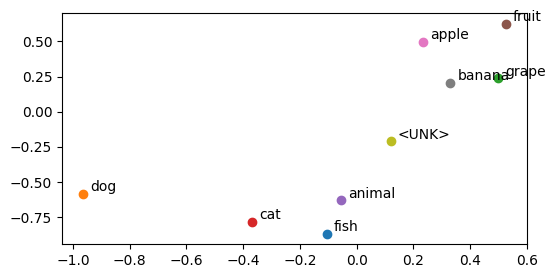

In [71]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word, xy= (x,y), xytext = (5,2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

In [72]:
banana = get_embed('banana')
banana

(0.33042243123054504, 0.20419059693813324)

In [73]:
unk = get_embed('<UNK>')
unk

(0.12097834050655365, -0.21044117212295532)

In [76]:
fruit = get_embed('fruit')
fruit

(0.5261388421058655, 0.626019299030304)

In [77]:
# more formally is to divide by its norm

def cosine_similarity (A,B):
    dot_product = np.dot(A,B)
    norm_a      = np.linalg.norm(A)
    nomr_b      = np.linalg.norm(B)
    similarity  = dot_product / (norm_a * nomr_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(unk)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

-0.03177768892109947
0.9497547203766165
